# Algorithme de Dijkstra (Metro parisien) - Janos Falke 2019

* 3. [Plus courts chemins dans le métro parisien](#3.-Plus-courts-chemins-dans-le-métro-parisien)<br>
    * 3.1 [Lier le fichier [i] et construire le graphe valué et orienté [ii]](#3.1-Lier-le-fichier-[i]-et-construire-le-graphe-valué-et-orienté-[ii])<br>
    * 3.2 [Adaptation de l'algorithme de Dijkstra pour l'exemple du Métro](#3.2-Adaptation-de-l'algorithme-de-Dijkstra-pour-l'exemple-du-Métro)<br>
    * 3.3 [Interface pour afficher le plus court chemin [pour faciliter l'utilisation]](#3.3-Interface-pour-afficher-le-plus-court-chemin-[pour-faciliter-l'utilisation])<br>
    * 3.4 [Exemples d’appels à la fonction dijkstra(x,y) \[iii\] et visualisation](#3.3-Exemples-d’appels-à-la-fonction-dijkstra[x,y]-[iii]-et-visualisation)<br>
        * 3.3.1 [Utilisation de l'interface](#3.3.1-Utilisation-de-l'interface)
        * 3.3.1 [Exemple simple [normal]](#3.3.2-Exemple-simple-[normal])<br>
        * 3.3.2 [Exemple avec station sens-unique](#3.3.3-Exemple-avec-station-sens-unique)<br>
        * 3.3.3 [Exemple avec stations non-existantes](#3.3.4-Exemple-avec-stations-non-existantes)<br>
        * 3.3.4 [Exemple avec un train direct [pas de changement de ligne]](#3.3.5-Exemple-avec-un-train-direct-[pas-de-changement-de-ligne])<br>
        * 3.3.5 [Exemple avec un chemin très long](#3.3.6-Exemple-avec-un-chemin-très-long)
---

## 3. Plus courts chemins dans le métro parisien


__*Informations supplémentaires:* __
* fonction *init_graph()* qui renvoit un nx.DiGraph() pour rémettre les couleurs du graphe à sa version initiale
* fonction *dijkstra(G,x,y)* visualise le graphe et renvoit un String avec les informations utiles pour l'utilisateur
---

__*Informations par rapport au changement pour l'interface (rendre l’utilisation plus agréable):*__<br>
Si on choisi un itinéraire dans l'interface et dans l'algorithme de dijkstra, on ne va pas aller d'une ligne/station à une autre ligne/station mais d'un arret à un autre. <br>
(Example: Montparnasse qui à plusieurs lignes donc on va pas choisir le départ depuis une de ces lignes mais de la Gare Montparnasse tout court, c'est pareil pour l'arrivée) <br>
Cela évite à l'utilisateur d'avoir un chemin qui commence ou qui finit par un changement à pied d'une ligne à une autre. Et on n'a plus besoin de préciser la station exacte dans l'interface donc l'utilisation devient plus agréable et facile.

---

### 3.1 Lier le fichier [i] et construire le graphe valué et orienté [ii]

In [8]:
#Nombre total = 1 (line 0)
#Descriptions = 3 (line 1, 378, 755)
#Nombre stations = 376 (line 2 à 377)
#Nombre coordonnées = 376 (line 379-754)
#Nombre d'arêtes = 932 (line 756-1688)

import networkx as nx

def init_graph():
    metroG = nx.DiGraph()

    #Lier le fichier et créer une liste (un élément pour chaque ligne)
    metroTextList = [line.rstrip('\n') for line in open('metro.graph', "r",encoding = "ISO-8859-1")]

    #Nombre de stations => première case du premier élément de la liste   
    nbStations = int(metroTextList[0].split(' ')[0])


    #Commencer à 2 parce qu'avant on n'a pas de valeurs, juste des informations (valeurs totales + description)
    i = 2
    while i < (nbStations+2): # +2 à cause des deux premières lignes
        numStation = int(metroTextList[i].split(' ')[0]) #récupérer numéro de la station
        nom = metroTextList[i].split(' ', 1)[1] #récupérer nom de la station

        #(i+nbStations+1) = commence ligne 379, pour stocker les coordonnées/position (+1 pour sauter la description "coord sommet")
        coord = (int(metroTextList[i+nbStations+1].split(' ')[1]),int(metroTextList[i+nbStations+1].split(' ')[2]))

        #Ajouter un sommet au graphe avec numéro,nom et coordonnées de la station + couleur non-visité (gris)
        metroG.add_node(numStation,color='gray', nom=nom, pos=coord, width=400)
        i += 1 

    #Nombre d'arrêts => deuxième case du premier élément de la liste    
    nbArcs = int(metroTextList[0].split(' ')[1])

    #Ajout des arrêts donc on va se placer sur la bonne ligne 
    i = len(metroTextList)-nbArcs-2          # (-2 pour sauter derniere ligne vide + description "arcs value")

    #Boucler sur les entrées des arrêtes jusqu'à la fin de la liste (-1 = dernier élément est vide)
    while i < len(metroTextList)-1:
        numStat = int(metroTextList[i].split(' ')[0]) #récupérer numéro de la station
        voisin = int(metroTextList[i].split(' ')[1]) #récupérer numéro de la station voisine
        distance = float(metroTextList[i].split(' ')[2]) #récupérer la distance entre les deux

        #Ajout d'une arrête au graphe avec numéro de station,numéro du voisin, distance entre les deux + couleur non-visité (gris)
        metroG.add_edge(numStat,voisin, color='gray', weight=distance, width=5)
        i += 1 
    
    return metroG


### 3.2 Adaptation de l'algorithme de Dijkstra pour l'exemple du Métro

In [9]:
import matplotlib.pyplot as plt
import datetime #pour pouvoir afficher à la fin la distance en format de 'time'

def dijkstra(G,start,dest,interfaceOn=False):
    
    #Paramètres du plot
    plt.rcParams['figure.figsize'] = (35,25) #Pour avoir un plot plus grand et en affichage plus agréable
    
    #Pour l'interface pour qu'on puisse prendre le premier element de la liste (ex. Montparnasse = (206,207,208,209))
    #Comme ca on peut eviter de faire des changements à pied (à la station de départ et station d'arrivée)
    if isinstance(start, (list,)):
        start = start[0]
        
    if isinstance(dest, (list,)):
        dest = dest[0]
        
    #Vérification si les points de départ et déstination sont bien existants
    if(start <= (len(G)-1) and  start >= 0 and dest <= (len(G)-1) and dest >= 0):
    
        #Initialisation du dictionnaire
        pCC = {}

        for v in G:
            #Ajouter tous les sommets v comme clé avec une distance de inf et le sommet précèdent non-existant (None)
            pCC.setdefault(v, {"Distance": float("inf"), "SommetPred": None})

        #Changer la distance du sommet de début à 0 
        pCC[start]["Distance"] = 0

        #Initialisation de la file prioritaire
        unvisited = list(pCC.keys())

        #Initialiser le sommet courant u au sommet de départ
        u = start

        #On boucle sur la file si elle n'est pas vide et le sommet courant n'est pas le sommet de la destination 
        while unvisited and u != dest:  

            for voisin in G[u]:
                #Comparer la distance actuelle du voisin avec la nouvelle distance du voisin (Distance "u" + Distance "u au voisin")
                if pCC[voisin]["Distance"] > pCC[u]["Distance"]+G[u][voisin]["weight"]:
                    pCC[voisin]["Distance"] = pCC[u]["Distance"]+G[u][voisin]["weight"] #mettre la distance à jour
                    pCC[voisin]["SommetPred"] = u #mettre le sommet courant comme sommet predecent dans le sommet voisin
                  
           #On enleve le premier et on trie les sommets non-visité (la file prio) par leurs distance (avec le dictionnaire)
            unvisited.remove(u)
            unvisited = sorted(unvisited, key=lambda x: pCC[x]["Distance"])
            u = unvisited[0] #Prendre le premier de la file (le plus court)

            
        ###Apres avoir trouvé le plus court chemin, on va colorier les sommets et arêtes et créer un string pour le chemin

        #On commence par la destination (à cause de l'argument "SommetPred") 
        # -> initialiser sommet courant, distance et le string "chemin"
        sommetCourant = dest 
        distance = pCC[dest]["Distance"]
        chemin = "None"
        
        #Stocker tous les noms des sommets dans un tableau pour pouvoir créer un beau affichage (numéro + nom)
        nodes = G.nodes()
        nom_nodes = [G.nodes[u]['nom'] for u in nodes]

        compteurCorrespondance = -1 #On ne compte ni le premier ni le dernier
        compteurChangement = 0

        #S'il existe un sommet precedent du sommet de destination on peut boucler (il existe un chemin)
        if pCC[sommetCourant]["SommetPred"] != None: 
            destination = pCC[sommetCourant]["SommetPred"]
            
            #On va supprimer la derniere correspondance s'il s'agit d'un changement à pied
            if G.nodes[destination]['nom'] == G.nodes[sommetCourant]['nom']:
                sommetCourant = destination
            
            chemin = nom_nodes[sommetCourant]+"(S"+str(sommetCourant)+")" #init le string chemin avec le sommet courant
            G.nodes[sommetCourant]['color'] = "orange" #changer la couleur du sommet courant (destination)
            G.nodes[sommetCourant]['width'] = 1000 #changer la couleur du sommet courant (destination)
            
            while G.nodes[sommetCourant]['nom'] != G.nodes[start]['nom']:
                
                G.edges[pCC[sommetCourant]["SommetPred"],sommetCourant]['color'] = "red"  
                G.edges[pCC[sommetCourant]["SommetPred"],sommetCourant]['width'] = 8

                #Si le sommet courant et le sommet précèdent sont les mêmes donc on se trouve dans la même station
                if (nom_nodes[sommetCourant] == nom_nodes[pCC[sommetCourant]["SommetPred"]]):
                    chemin = nom_nodes[pCC[sommetCourant]["SommetPred"]]+ "(S"+str(pCC[sommetCourant]["SommetPred"])+") \t\n[Changement à pied / de ligne (même station)]\n=> "+chemin
                    compteurChangement += 1
                    
                else :
                    chemin = nom_nodes[pCC[sommetCourant]["SommetPred"]]+ "(S"+str(pCC[sommetCourant]["SommetPred"])+") \n"+"-> "+chemin
                
                #Mettre à jour le sommet courant, la couleur du sommet visité et incrémente le compteur de correspondance
                sommetCourant = pCC[sommetCourant]["SommetPred"]
                
                if G.nodes[sommetCourant]['nom'] != G.nodes[start]['nom']:
                    G.nodes[sommetCourant]['color'] = "red"
                    G.nodes[sommetCourant]['width'] = 650
                else: 
                    G.nodes[sommetCourant]['color'] = "blue"
                    G.nodes[sommetCourant]['width'] = 1000
                compteurCorrespondance += 1
            
        ###Dessiner/Visualiser le graphe  
    
        #Récupérer arêtes (sommets déjà récupérer pour les noms [dans 'nodes'])
        edges = G.edges()

        #Récupérer les couleurs des arêtes et sommets
        color_edges = [G[u][v]['color'] for u,v in edges]
        color_nodes = [G.nodes[u]['color'] for u in nodes]
        
        
        #Récupérer les poids (distances) des arêtes et les noms des stations
        edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
        labels = dict([((u),d['nom']) for u,d in G.nodes(data=True)])

        #Récuperer les largueurs des sommets et arêtes
        edge_widths= [G[u][v]['width'] for u,v in edges]
        node_widths= [G.nodes[u]['width'] for u in nodes]
        
        #Récupérer les positions des sommets
        positions_nodes =nx.get_node_attributes(G,'pos')

        ##Affichage interface
        if interfaceOn:
            #Effacer le contenu du plot (pour l'affichage dans l'interface pour refaire un dessin du graphe en supprimant l'ancien)
            plt.clf() #Pour l'interface
            nx.draw_networkx(G, positions_nodes, with_labels=False, edge_color=color_edges, node_color=color_nodes,arrows=False,width=edge_widths,node_size=node_widths)
        
        ##Affichage sans interface
        else :
            #Dessiner avec networkx les sommets, arêtes et labels (sans labels)
            nx.draw_networkx(G, positions_nodes, with_labels=True , edge_color=color_edges, node_color=color_nodes, arrows=False,width=edge_widths,node_size=node_widths)
            nx.draw_networkx_edge_labels(G, positions_nodes, edge_labels=edge_labels, font_size=10)
            nx.draw_networkx_labels(G, positions_nodes, labels, font_size=12)
        
        #Enlever les axes
        plt.axis('off')
        
        if interfaceOn:
            plt.savefig("graph.png",dpi=80, format="PNG") #Pour l'interface (faciliter affichage du graphe)
            plt.close() #Pour ne pas afficher la photo sauvegardé en sortie quand la fonction startInterface() est appelée
            
        else:
            plt.show
            
        #Création des string à renvoyer (informations pour l'utilisateur)
        if(start != dest):
            trainDirect = ""
            if (compteurChangement == 0): trainDirect = "| *** Train direct *** | \n"
            td = datetime.timedelta(seconds=distance)
            mins,secs = td.seconds // 60, td.seconds % 60
            
            strStartDest = "* Départ: " + nom_nodes[start] + " *\n* Arrivée: " + nom_nodes[dest] + " *\n\n"
            strDistCorresp = "\n \n"+trainDirect+"* Temps total du voyage: "+str(mins)+" minutes et "+str(secs)+" secondes *\n* Nombre de correspondances/arrêtes: "+str(compteurCorrespondance)+" *\n* Changements de ligne: "+str(compteurChangement)+" *"
        
            return strStartDest + chemin + strDistCorresp
        else:
            return "ERREUR: Même station de départ et arrivée!"
    
    #Si les points de départ et déstination ne sont pas existants donc on renvoie une erreur
    else: 
        return "ERREUR: Le départ et/ou l'arrivée n'existe pas (Stations seulement entre 0 et "+ str(len(G)-1) +")."
    

### 3.3 Interface pour afficher le plus court chemin [pour faciliter l'utilisation]

In [10]:
from tkinter import*
import io
import os
from PIL import Image, ImageTk 

def startInterface():
    #On cree la fenetre principale
    root = Tk()
    root.title("Interface : Trouver le plus court chemin entre deux stations du métro parisien")
    root.option_add('*font', ('FixedSys', 14))
    root.configure(background='white')
    root.attributes("-topmost", True)
    root.update_idletasks()
    
    
    ########## A TESTER ############
    #Centrer la fenetre principale
    def center_window(w, h):
        ws = root.winfo_screenwidth()
        hs = root.winfo_screenheight()
        # calculate position x, y
        x = (ws/2) - (w/2)    
        y = (hs/2) - (h/2)
        root.geometry('%dx%d+%d+%d' % (w, h, x, y))
    center_window(1250, 700) 
    ###############################
    
    #Création d'une premiere partie en haut
    pw1 = PanedWindow(root, height=100,width=1200)
    pw1.pack(expand = 1,pady=30)
    pw1.update_idletasks()

    #Création d'un frame dans la partie en haut et ajout à la fenetre haute
    entete = Frame(pw1, width=1250, height=100,borderwidth=2, relief="sunken", bg="#f2f2f2")
    pw1.add(entete)
    entete.pack(side=TOP)
    entete.update_idletasks()

    #Création d'une deuxieme partie en bas 
    pw2 = PanedWindow(root,height =600,width=1250,orient = 'horizontal')
    pw2.pack(expand = 1, pady=30, padx= 20)

    #Création de 4 frames dans la partie basse
    depart = LabelFrame(pw2, width= 150, height=600, text="Choisir Départ" ,bg="#f2f2f2",fg="blue",relief="sunken")
    arrivee = LabelFrame(pw2, width= 150, height=600, text="Choisir Arrivée", bg="#f2f2f2", fg="#ea8400",relief="sunken")
    infosChemin = LabelFrame(pw2, width=350, height=600, text="Description du chemin", bg="#f2f2f2",relief="sunken")
    visuelGraphe = LabelFrame(pw2,width=600,height=600, text="Affichage du chemin sur le métro", bg="#f2f2f2",relief="sunken")

    #Ajouter à la fenetre basse
    pw2.add(depart)
    depart.pack(side=LEFT)
    pw2.add(arrivee)
    arrivee.pack(side=LEFT)
    pw2.add(infosChemin)
    infosChemin.pack(side=LEFT)
    pw2.add(visuelGraphe)
    visuelGraphe.pack(side=LEFT)
    
    #Dire que ses enfants ne controllent pas leurs taille 
    entete.pack_propagate(0)
    depart.pack_propagate(0)
    arrivee.pack_propagate(0)
    infosChemin.pack_propagate(0)
    visuelGraphe.pack_propagate(0)


    #Initialiser le graphe du metro pour l'interface
    metroG = init_graph()

    #Initialiser un tableau avec 2 elements vides (depart, arrivee)
    dijkstraPath = ["",""]

    
    #Action du bouton pour lancer la fonction dijkstra, afficher les informations et visualiser le graphe 
    def clicked():
        graphMetro = dijkstra(init_graph(),dijkstraPath[0],dijkstraPath[1],True)

        #Une liste des informations 
        chemin.delete(0,END) #Enlever s'il y a déjà quelque chose dedans
        for line in graphMetro.splitlines():
            chemin.insert(END,line)
        chemin.pack(expand = True, fill = BOTH)

        #Charger la photo enregistré par dijkstra et mettre la bonne taille à place
        im = PhotoImage(master= visuelGraphe, file="graph.png")
        im = im.zoom(2) 
        im = im.subsample(9) 
        
        #Mettre l'image dans le label correspondant
        dessin.configure(image=im)
        dessin.image = im
        dessin.pack()


    #Création du bouton 
    btn = Button(entete, text="Trouver le plus court chemin", command=clicked).pack(pady=20)


    #Création de la liste et du titre pour les informations
    labelfont = ('times', 14)
    chemin = Listbox(infosChemin, justify=LEFT)
    chemin.config(font=labelfont)                
    chemin.pack(expand=YES, fill=BOTH)


    #####frameDessin = Frame(visuelGraphe, width=500,height=400,bd=8,relief="ridge").pack(side=LEFT)
    dessin = Label(visuelGraphe, width=500,height=400,bd=8,relief="ridge")
    
    
    #Créer l'entete avec le depart et l'arrivee
    stationDepart = StringVar()
    stationArrivee = StringVar()
    enteteDepart = Label(entete,textvariable=stationDepart)
    enteteArrivee = Label(entete,textvariable=stationArrivee)
    stationDepart.set("Départ: ...")
    stationArrivee.set("Arrivée: ...")
    enteteDepart.place(x=320,y=60)   
    enteteArrivee.place(x=entete.winfo_width()-450,y=60) 

    #Fonctions pour la selection d'un element d'une liste 
    def selectedDepart(evt):
        w = evt.widget
        index = int(w.curselection()[0])
        value = w.get(index)
        dijkstraPath[0] = stations[value] #Mettre le depart a jour
        stationDepart.set("Départ: "+value)


    def selectedArrivee(evt):
        w = evt.widget
        index = int(w.curselection()[0])
        value = w.get(index)
        dijkstraPath[1] = stations[value] #Mettre l'arrivée a jour
        stationArrivee.set("Arrivée: "+value)

  

    #Création des deux listes (depart et arrivee) puis appliquer quand on a choisi un element dans chaque liste
    listDepart=Listbox(depart,exportselection=0,height=200)
    listArrivee=Listbox(arrivee,exportselection=0,height=200)
    listDepart.bind('<<ListboxSelect>>',selectedDepart)
    listArrivee.bind('<<ListboxSelect>>',selectedArrivee)

    #Mettre tous les noms des stations (sommets) dans une liste
    nomStations = list([((u),d['nom']) for u,d in metroG.nodes(data=True)])

    #Créer un dictionnaire avec les différentes stations + leurs lignes (ex. Montparnasse : (206,207,208,209))
    stations = dict()
    i = 0     
    for nomStation in nomStations:
        nom = nomStation[1]
        if nom in stations:
            stations[nom].append(i)    
        else:
            stations[nom] = [i]
        i+=1
    
    #Ajouter tous les noms dans les deux Listbox (que les differentes stations (pas 2 fois la même station!))
    for nom in stations.keys():
        listDepart.insert(END,nom)
        listArrivee.insert(END,nom)
    
    #Placer les éléments
    listDepart.pack(padx=10,pady=10)
    listArrivee.pack(padx=10,pady=10)

    #Lancer l'application
    
    def on_closing():
        #Détruire la photo crée si elle existe
        if os.path.isfile("graph.png"): 
            os.remove("graph.png") 
        root.destroy()

    root.protocol("WM_DELETE_WINDOW", on_closing)
    
    root.mainloop()

### 3.3 Exemples d’appels à la fonction dijkstra[x,y] [iii] et visualisation

__*Informations:*__<br>
Ici on a la possibilité d'afficher une interface ou de faire des exemples en ligne de commande. On a ajouté des exemples en ligne de commande mais il est préférable d'utiliser l'interface ou l'utilisation est très agréable.

---

#### 3.3.1 Utilisation de l'interface

In [11]:
startInterface()

---

__<font color=red>Attention !</font>__<br>
A chaque éxécution d'un exemple on va reinitialiser le graphe du métro (avec notre fonction 'init_graph()' sinon il va garder les sommets et arrêtes visités précédemment.

Pour avoir un affichage encore plus beau, et plus lisible il faudrait augmenter la taille du plot et aussi la taille des noms des sommets (pour ne pas avoir un plot trop grand ici les informations ne sont pas très lisibles mais on peut augmenter cela facilement dans la fonction dijkstra).<br>
*(La visualisation du graphe peut prendre un petit moment)*

#### 3.3.2 Exemple simple [normal]

* Départ: Belleville *
* Arrivée: Pont-Neuf *

Belleville(S20) 
-> Goncourt(S129) 
-> République(S311) 
-> Arts et Métiers(S7) 
-> Rambuteau(S290) 
-> Hôtel de Ville(S136) 
-> Châtelet(S68) 	
[Changement à pied / de ligne (même station)]
=> Châtelet(S71) 
-> Pont-Neuf(S255)
 
* Temps total du voyage: 8 minutes et 50 secondes *
* Nombre de correspondances/arrêtes: 7 *
* Changements de ligne: 1 *


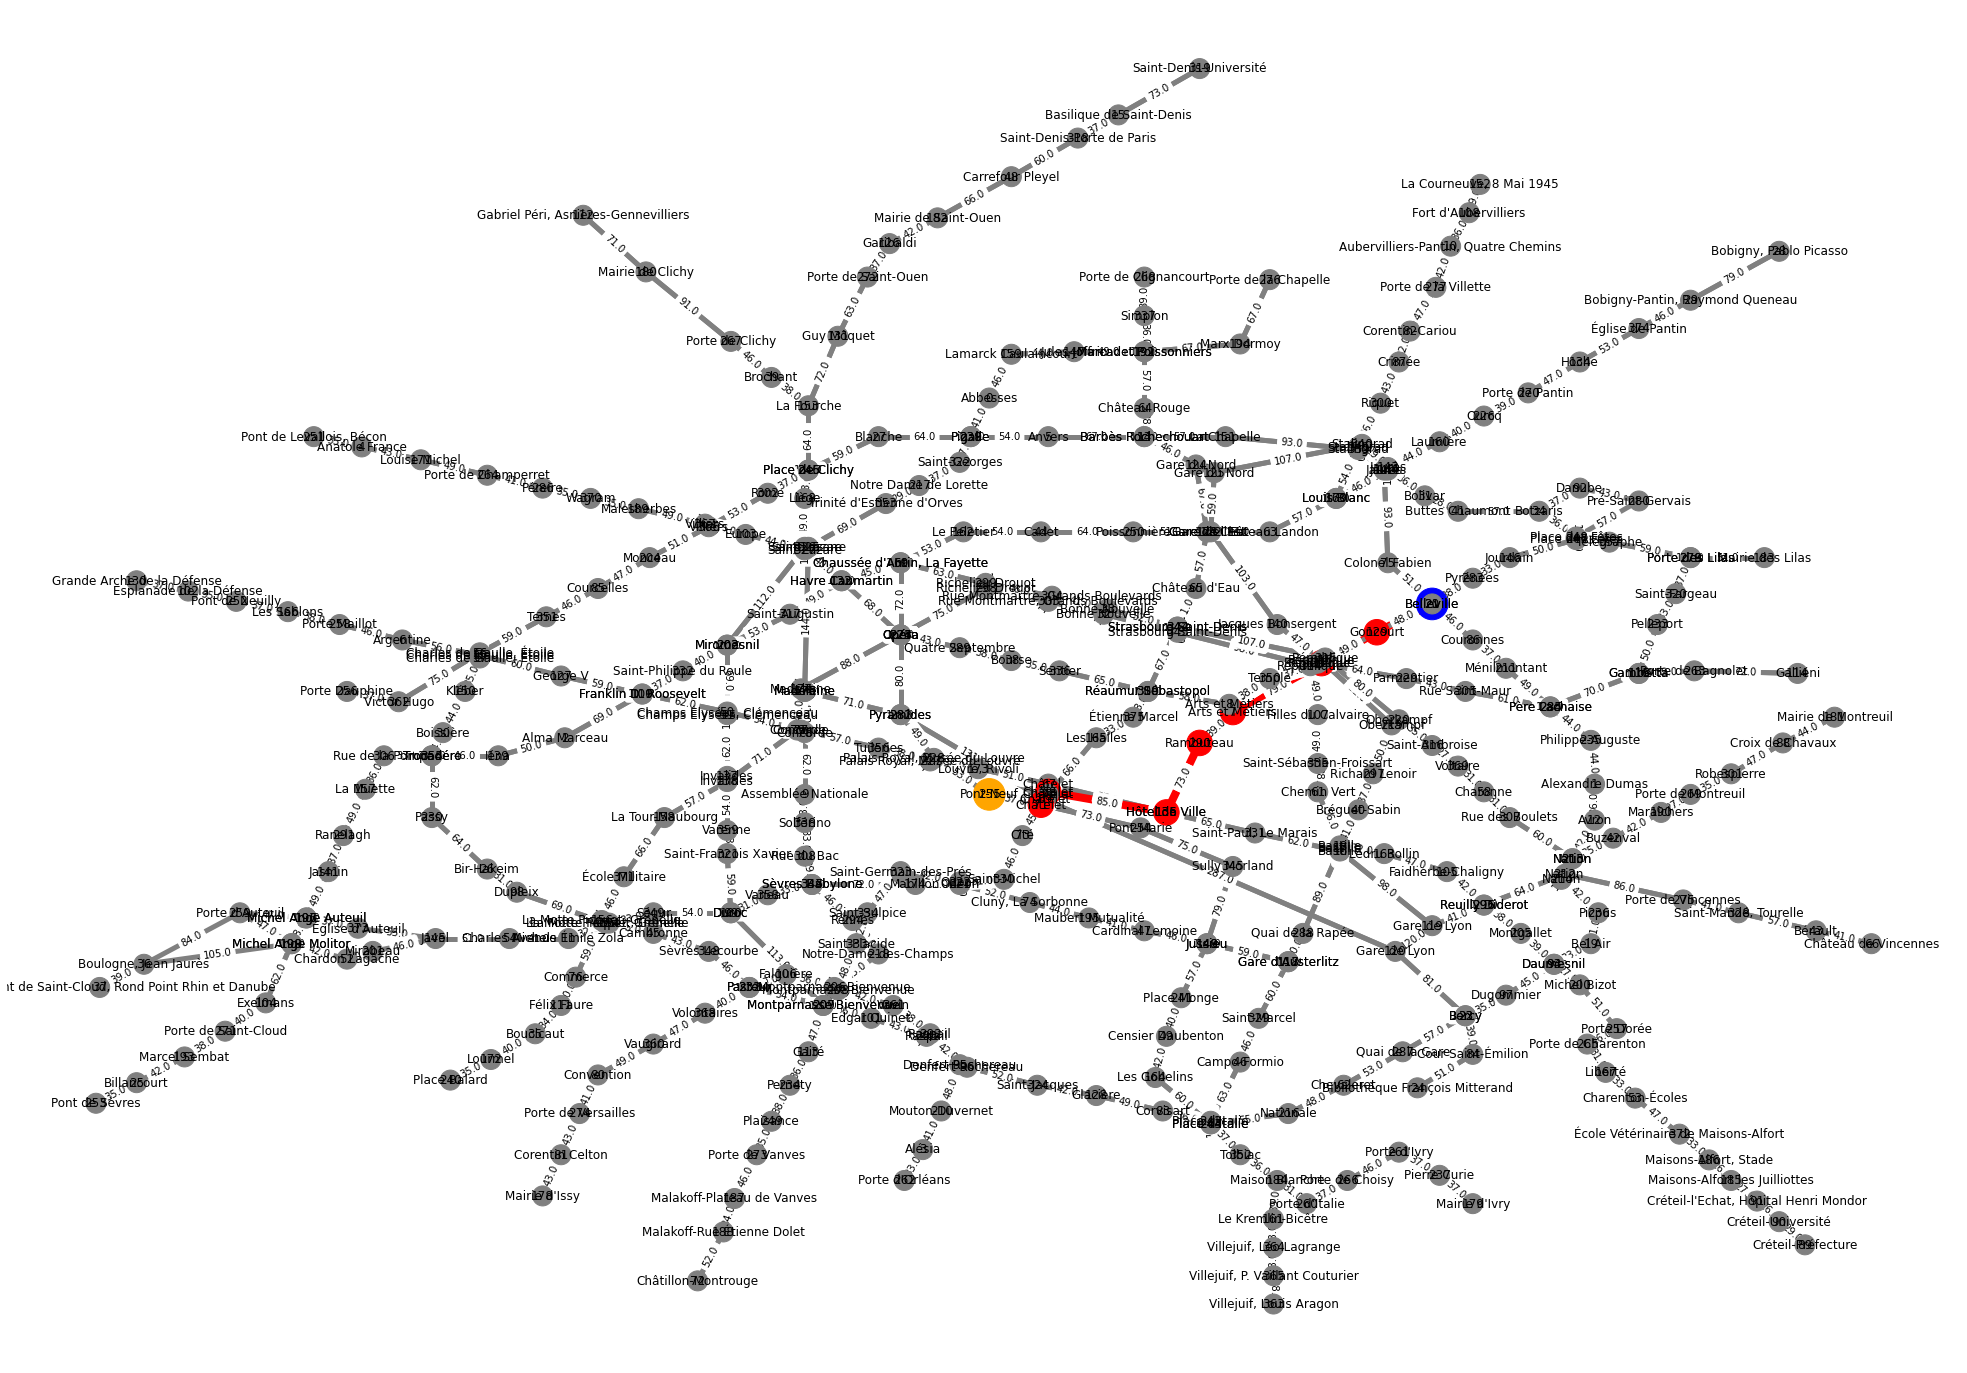

In [7]:
G1 = init_graph()
route = dijkstra(G1,20,255)

print(route)

#### 3.3.3 Exemple avec station sens-unique 

Information: *Dans ce exemple car on a une station avec un sens-unique les deux chemins X à Y et Y à X n'ont pas la même distance et mêmes correspondances.* <br>
Ici notre station sens-unique est Porte d'Auteuil(259).

* Départ: Abbesses *
* Arrivée: Montparnasse Bienvenue *

Abbesses(S0) 
-> Pigalle(S238) 
-> Saint-Georges(S322) 
-> Notre Dame de Lorette(S217) 
-> Trinité d'Estienne d'Orves(S353) 
-> Saint-Lazare(S325) 
-> Madeleine(S175) 
-> Concorde(S78) 
-> Assemblée Nationale(S9) 
-> Solférino(S338) 
-> Rue du Bac(S308) 
-> Sèvres Babylone(S347) 
-> Rennes(S294) 
-> Notre-Dame-des-Champs(S218) 
-> Montparnasse Bienvenue(S206)
 
| *** Train direct *** | 
* Temps total du voyage: 13 minutes et 9 secondes *
* Nombre de correspondances/arrêtes: 13 *
* Changements de ligne: 0 *


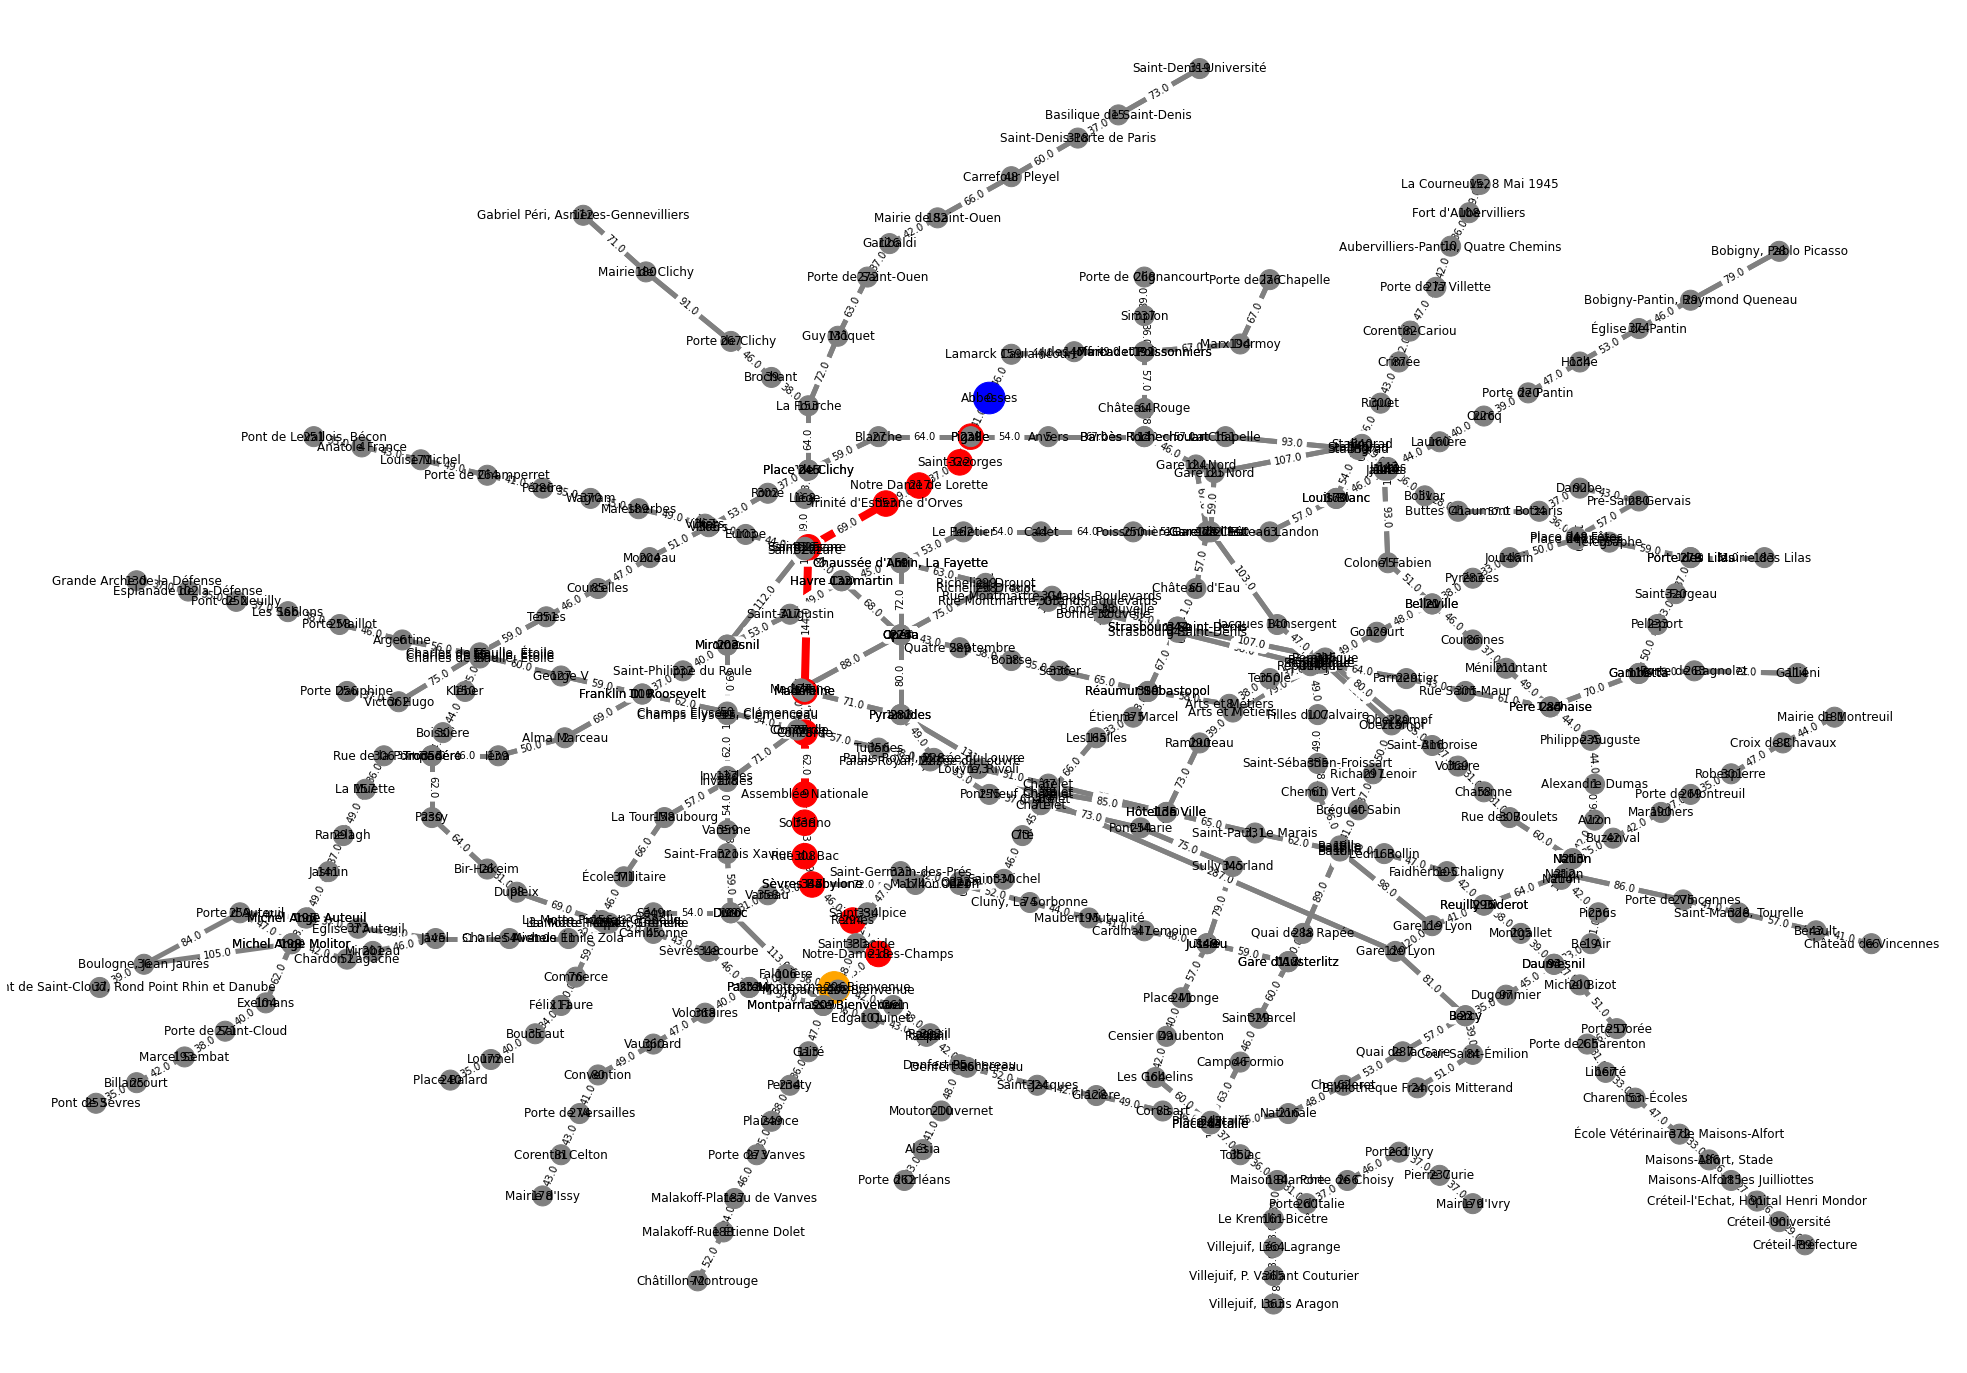

In [12]:
#De 198 (Michel Ange Molitor) à 259 (Porte d'Auteuil)
G2 = init_graph()

route2 = dijkstra(G2,0,207)

print(route2)

In [ ]:
#De 259 (Porte d'Auteuil) à 198 (Michel Ange Molitor)
G2_2 = init_graph()
route2_2 = dijkstra(G2_2,347,198)

print(route2_2)

#### 3.3.4 Exemple avec stations non-existantes

In [ ]:
G3 = init_graph()
route3 = dijkstra(G3,0,400)

print(route3)

#### 3.3.5 Exemple avec un train direct [pas de changement de ligne]

In [ ]:
G4 = init_graph()
route4 = dijkstra(G4,319,153)

print(route4)

#### 3.3.6 Exemple avec un chemin très long

* Départ: Alexandre Dumas *
* Arrivée: Alésia *

Alexandre Dumas(S1) 
-> Avron(S12) 
-> Nation(S213) 	
[Changement à pied / de ligne (même station)]
=> Nation(S214) 
-> Picpus(S236) 
-> Bel Air(S19) 
-> Daumesnil(S93) 
-> Dugommier(S97) 
-> Bercy(S23) 
-> Quai de la Gare(S287) 
-> Chevaleret(S62) 
-> Nationale(S216) 
-> Place d'Italie(S243) 
-> Corvisart(S83) 
-> Glacière(S128) 
-> Saint-Jacques(S324) 
-> Denfert Rochereau(S96) 	
[Changement à pied / de ligne (même station)]
=> Denfert Rochereau(S95) 
-> Mouton-Duvernet(S210) 
-> Alésia(S3)
 
* Temps total du voyage: 16 minutes et 25 secondes *
* Nombre de correspondances/arrêtes: 18 *
* Changements de ligne: 2 *


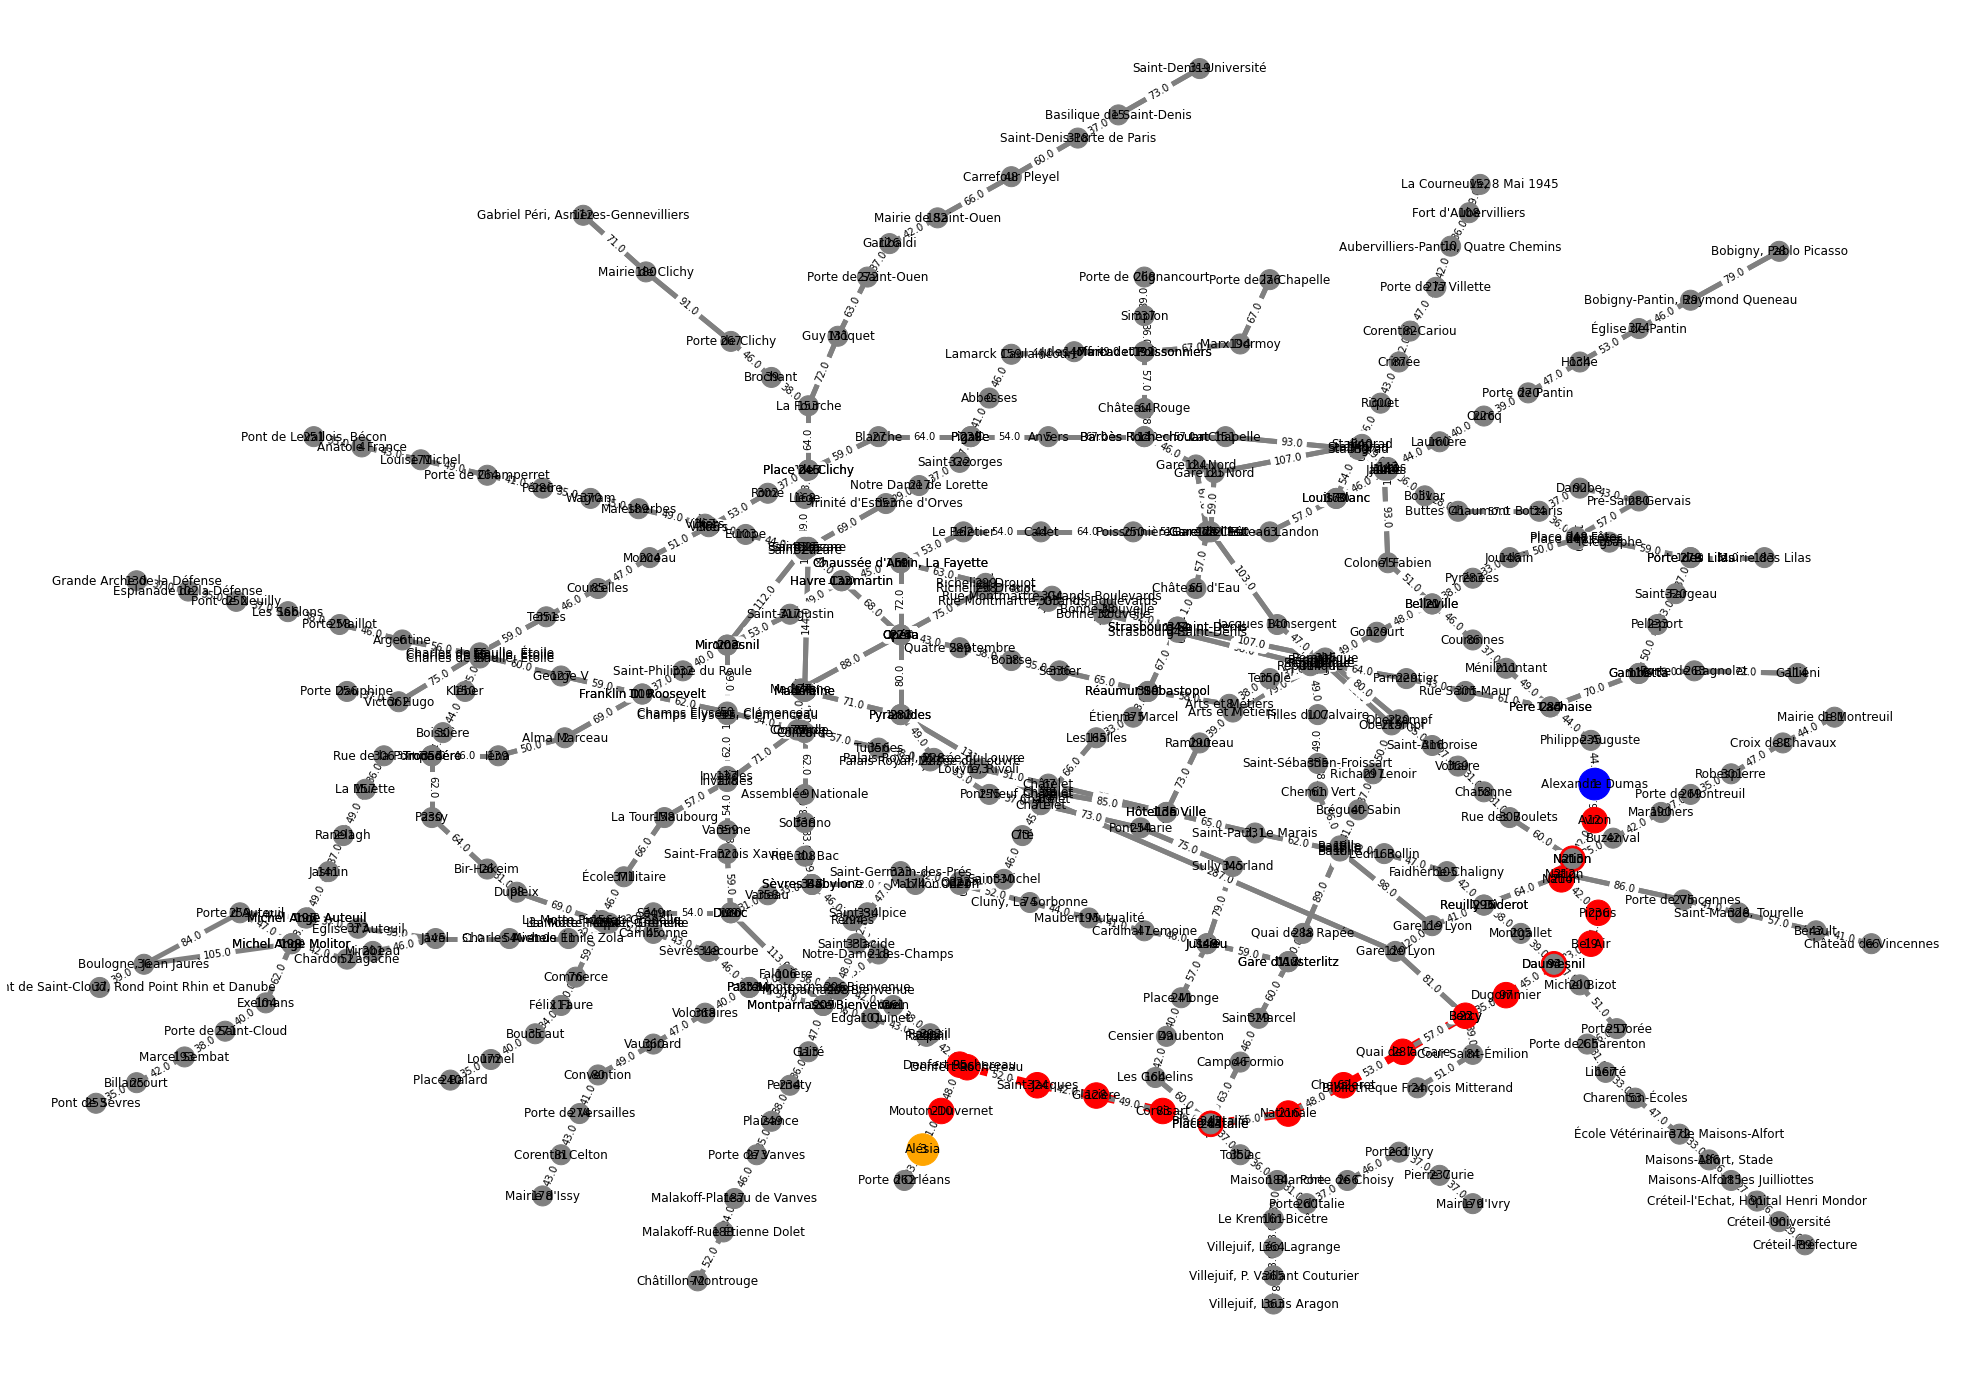

In [13]:
G5 = init_graph()
route5 = dijkstra(G5,1,3)

print(route5)